# SRP 2021 Prof. Gil Eckert, Isabella Chiaravalloti, and Anna Nardelli

## Programs that receive ABET accreditation meet certain quality standards that assure the program’s graduates are prepared for employment in computer science careers as they enter the workforce. Part of the accreditation process seeks to affirm that the courses taught reflect the advertised curriculum and embody the ABET accreditation outcomes. This project sought to develop a metric to gauge the level of alignment between course syllabi from the computer science (CS) curriculum at Monmouth University (MU) to descriptions found in the MU course catalog and to ABET computer science accreditation outcomes. A method called Natural Language Processing (NLP) was used to analyze these documents for each course in the program. 

### Imports

In [5]:
import pickle
from nltk.tokenize import word_tokenize
import nltk
from nltk.corpus import stopwords
import requests
import re
import string

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Our imports were used to access, store, and analyze the data used in our program. Below you will find a basic description of how each import was used in the project.

-pickle: to store large lists to be called later in the program

-nltk: NLP library, used to tokenize data (separate each word into elements of a list) and remove stop words

-requests: to access the documents from GitHub into the program

-matplotlib: makes charts using gathered data

-pandas: makes data frames/series/charts using gathered data

-numpy: for large lists and mathematical functions

### Functions

The wordFrequency function finds the words that the syllabus/course description have in common and creates a word frequency chart for each course:

In [13]:
def wordFrequency(syl, cc, string, count):
    #new lists for each doc and one for common words
    data = []
    syllabus = []
    catalog = []
    
    #finds common words and inserts them into a list with each common word ocurring only once
    for word in cc:
        if word in syl:
            data.append(word)
    for word in syl:
        if word in data:
            syllabus.append(word)     
    for word in cc:
        if word in data:
            catalog.append(word)
            
    #creates pandas series for each doc and sorts by index
    seriesSyl = pd.Series(syllabus)
    seriesCC = pd.Series(catalog)
    syllabusCount = seriesSyl.value_counts().sort_index()
    catalogCount = seriesCC.value_counts().sort_index()
    #print(syllabusCount)
    #print(catalogCount)
    
    #sets maximum, which will determine chart height
    maximum = 0
    max1 = max(syllabusCount)
    max2 = max(catalogCount)
    if max1 > max2:
        maximum = max1
    else:
        maximum = max2
   
    #sets up chart output files
    fileName = " "
    if string == "outcomes":
        legendLabel = "Outcomes"
        title = courses[count] + " Syllabus vs. Outcomes"
        wordSimilarity(syllabusCount, catalogCount, "outcomes")
        fileName = courses[count] + 'Outcomes.png'
    else:
        legendLabel = "Course Catalog"
        title = courses[count] + " Syllabus vs. Course Catalog"
        wordSimilarity(syllabusCount, catalogCount, "cc")
        fileName = courses[count] + 'CC.png'
    
    #creates charts and shows/saves to file
    plt.figure(figsize=(12,8))
    plt.plot(syllabusCount, label = "Syllabus", color = colors[0])
    plt.plot(catalogCount, label = legendLabel, color = colors[1])
    plt.xticks(rotation=90)
    plt.xlabel("Words")
    plt.yticks(np.arange(1, maximum+1, 1))
    plt.ylabel("Frequency")
    plt.legend(loc="upper left")
    plt.title(title)
    plt.savefig(fileName)
    plt.show()

wordSimCC = []
wordSimOut = []

The wordSimilarity function is used to execute the mathematical function that determines the similarity corellation score for each course:

In [14]:
def wordSimilarity(syl, cc, string):
    #WORD SIMILARITY = (CC WORD COUNT / CC TOTAL WORD COUNT) * (LESSER OF SYL WORD COUNT AND CC WORD COUNT)
    syl = syl.tolist()
    cc = cc.tolist()
    total = 0
    lesser = 0
    ccLength = 0
    count = 0
    for ccWord in cc:
        ccLength += ccWord
    for ccWord in cc:
        if syl[count] < ccWord:
            lesser = syl[count]
        else:
            lesser = ccWord
        count+=1
        wordSim = ((ccWord/(ccLength)) * (lesser))
        total = wordSim + total
    #separates Outcomes data from CC data, allowing this function to be used for both types of documents
    if string == "outcomes":
        wordSimOut.append(total)
    else:
        wordSimCC.append(total)

The descSplit function cleans the data from each course description. It tokenizes the data, makes all words lowercase, removes punctuation and other non-alphabetic characters, and filters out stop words. It also returns the list of clean data:

In [15]:
def descSplit(desc):
    descText = " ".join(desc)
    tokens = word_tokenize(descText) 
    #convert to lower case
    tokens = [w.lower() for w in tokens]
    #remove punctuation from each word
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    #remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    #filter out stop words
    stop_words = set(stopwords.words('english'))
    new_stopwords = ['ł']
    new_stopwords_list = stop_words.union(new_stopwords)
    words = [w for w in words if not w in new_stopwords_list]
    return words

The desc function is used to extract the course description data needed from the Monmouth University Course Catalog. This document is over 600 pages, and this code automated the process of searching the document and pulling out only the data we needed.

In [16]:
def desc(cc, start):
    desc = []
    desc.append(cc[start])
    desc.append(cc[start + 1])
    start += 2
    while not cc[start].startswith("CS-"):
        desc.append(cc[start])
        start += 1
    desc = descSplit(desc)
    return desc

### Main Code

In [17]:
courses = ['CS-102', 'CS-104', 'CS-175', 'CS-175L', 'CS-176', 'CS-176L', 'CS-205', 'CS-205L', 'CS-286', 'CS-305', 'CS-310', 'CS-325', 'CS-414', 'CS-418', 'CS-432', 'CS-450', 'CS-490', 'CS-492A']
urlList = [l.replace('-','') for l in courses]

colors = ["#4285f4", "#ea4335"]

In [18]:
#SYLLABUS
sylList = []

#for loop takes each course and executes these steps separately for each syllabus
for u in urlList:
    
    #pulls data from the URL and writes it into a string
    sylURL = "https://raw.githubusercontent.com/annanardelli/SRP2021/main/CS%20ABET/" + u + ".txt"
    sylPage = requests.get(sylURL)
    sylData = sylPage.text

    if "\n" in sylData:
        sylData = sylData.replace("\r", "")
    else:
        sylData = sylData.replace("\r", "\n")

    #tokenizes the syllabi
    tokens = word_tokenize(sylData) 
    #convert to lower case
    tokens = [w.lower() for w in tokens]
    #remove punctuation from each word
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    #remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    #filter out stop words
    stop_words = set(stopwords.words('english'))
    new_stopwords = ['ł']
    new_stopwords_list = stop_words.union(new_stopwords)
    words = [w for w in words if not w in new_stopwords_list]
    sylList.append(words)
    
    #pickles the cleaned syllabus into a .txt file
    file_name = u + "Syllabus.txt"
    open_file = open(file_name, "wb")
    pickle.dump(words, open_file)
    open_file.close()
    open_file = open(file_name, "rb")
    loaded_list = pickle.load(open_file)
    open_file.close()

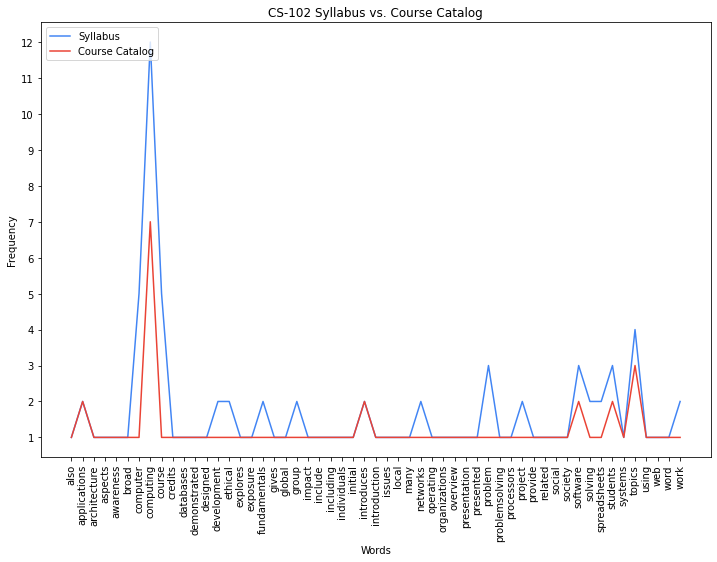

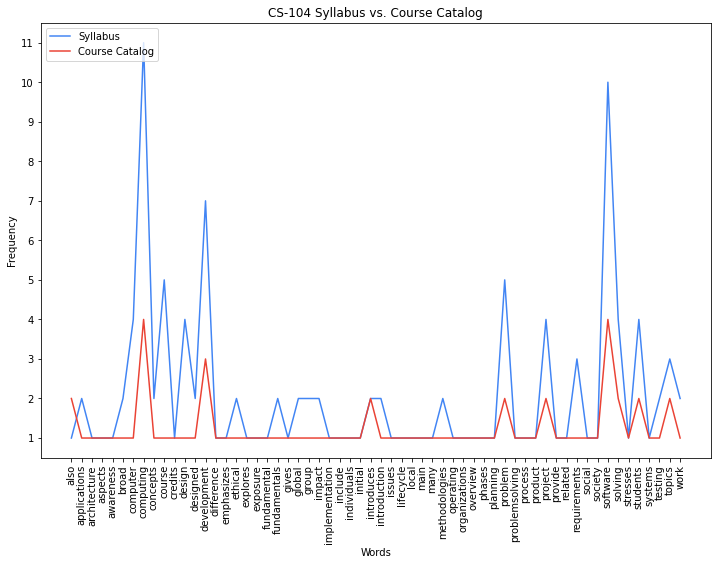

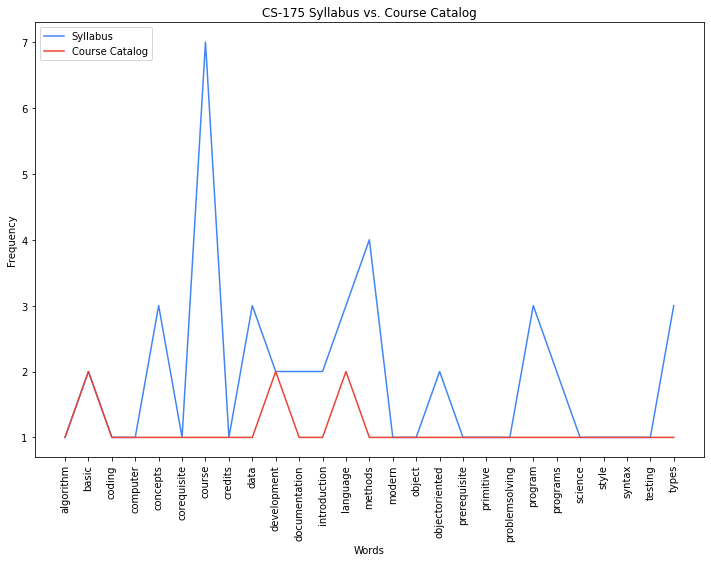

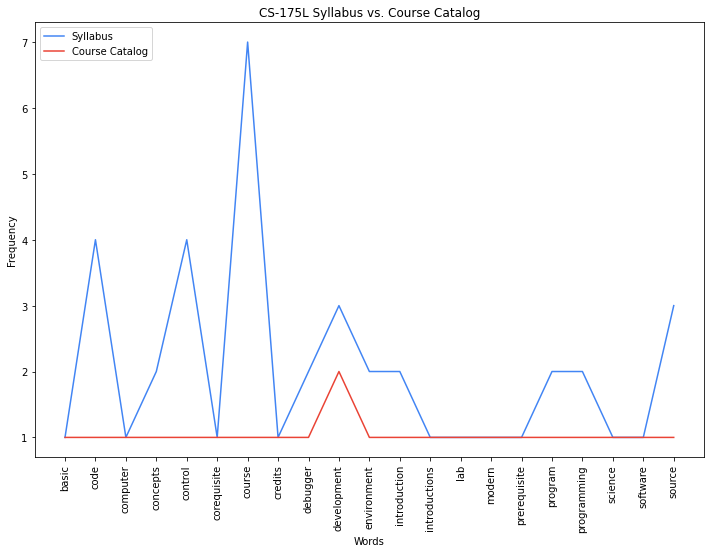

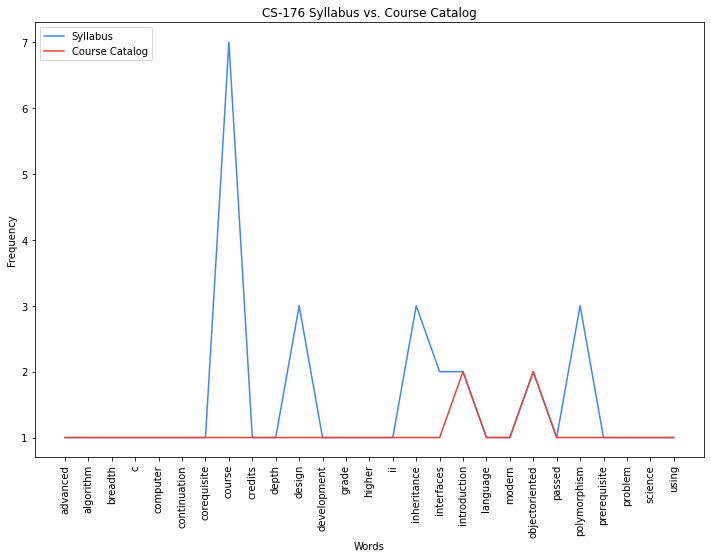

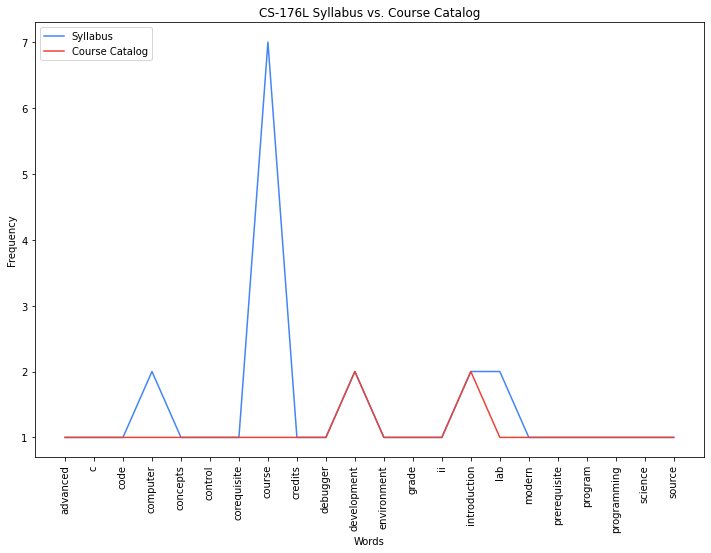

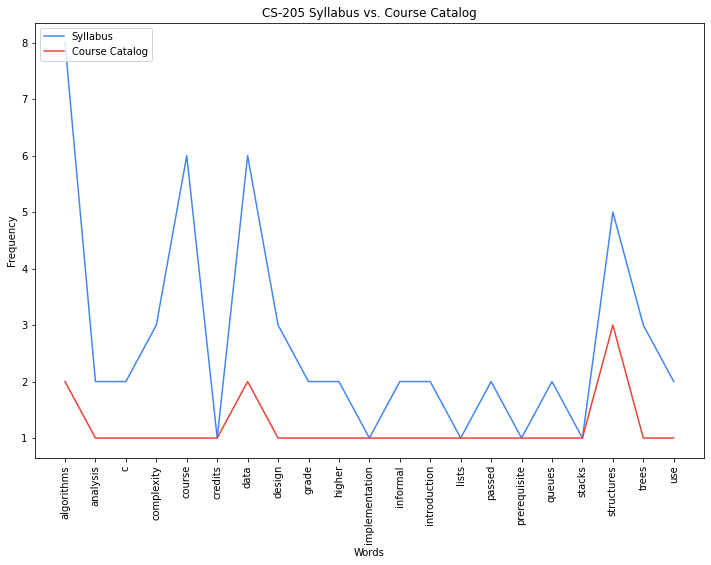

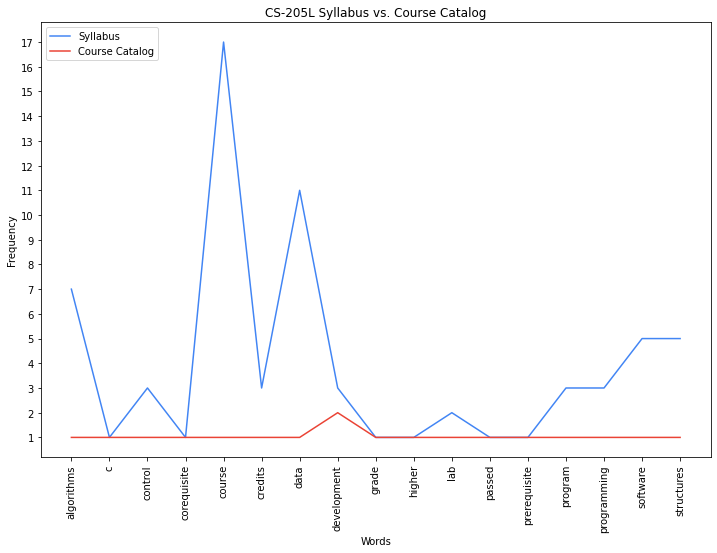

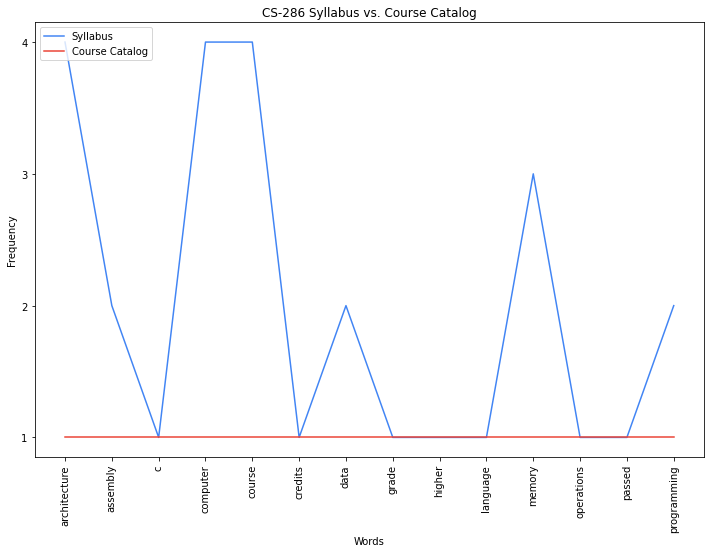

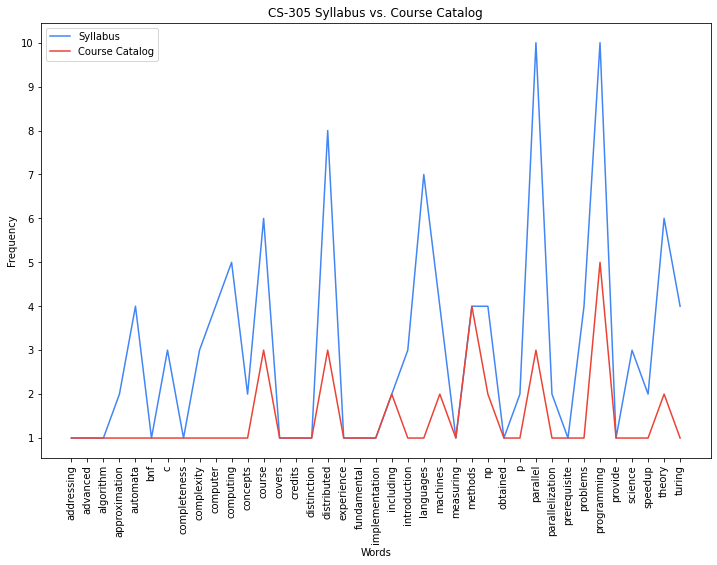

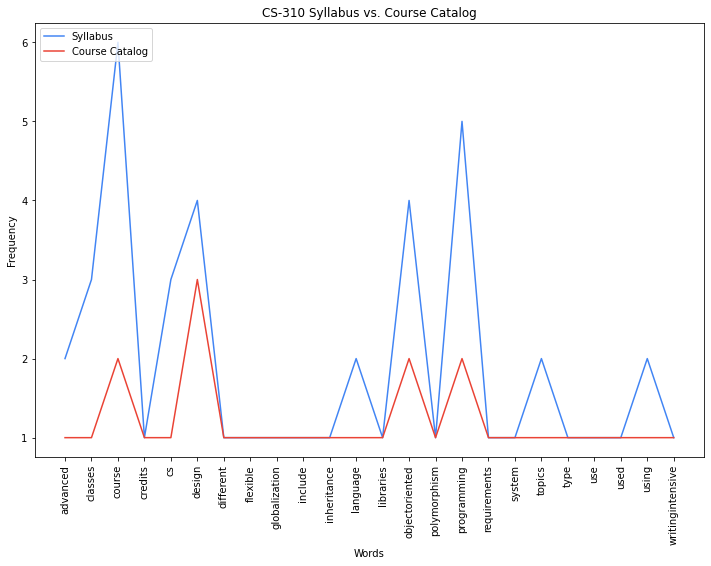

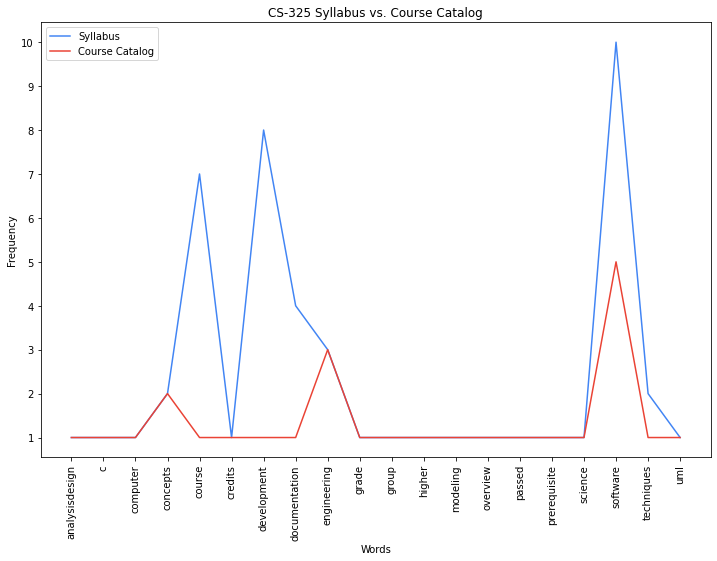

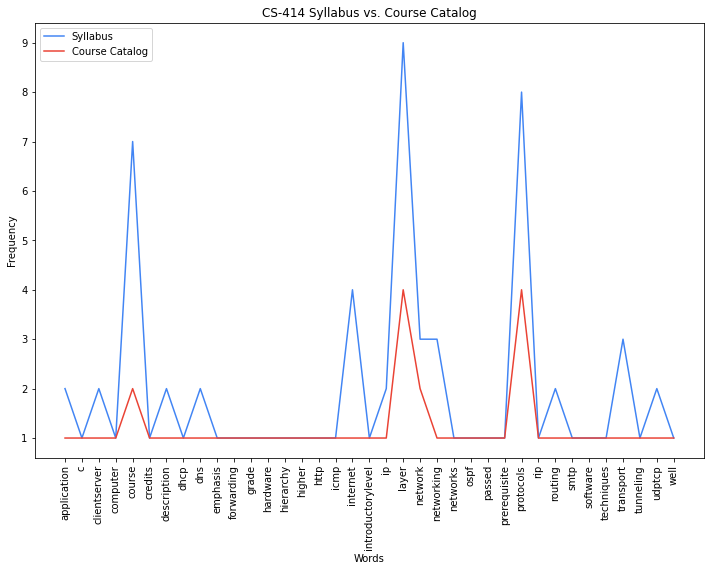

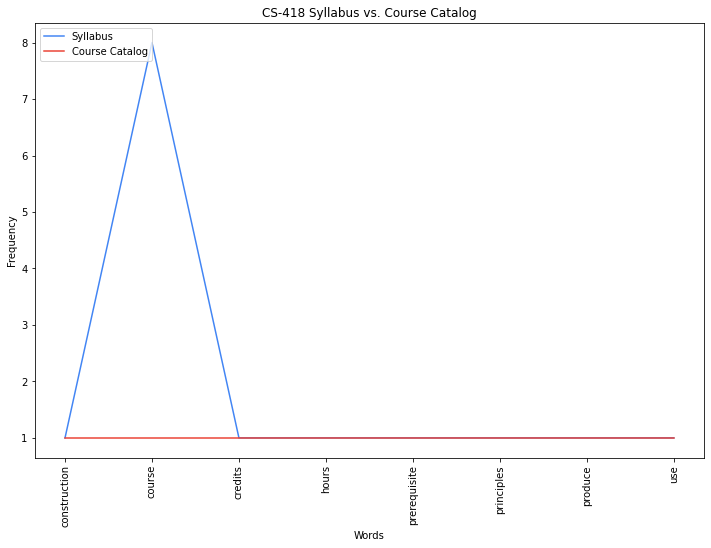

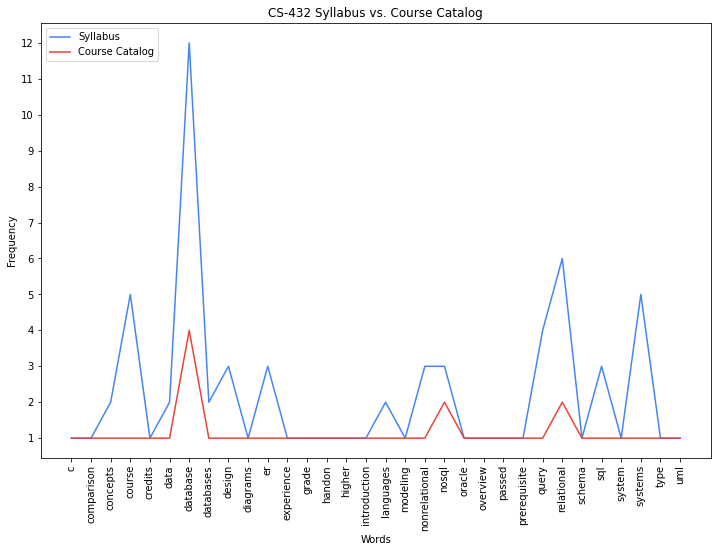

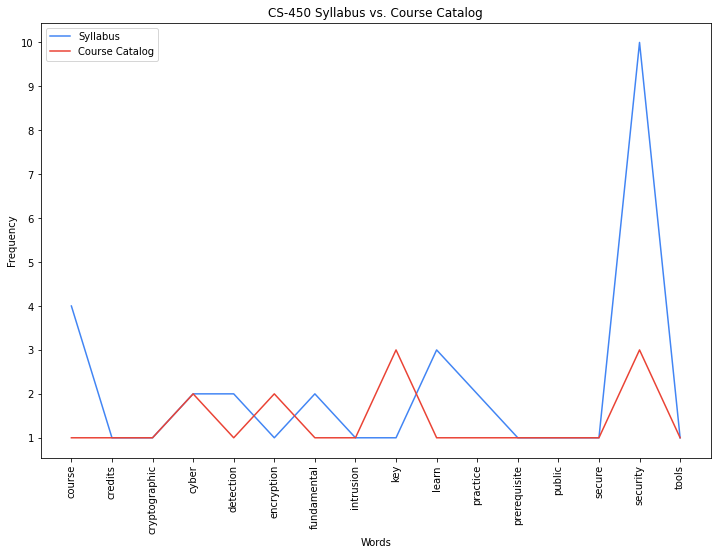

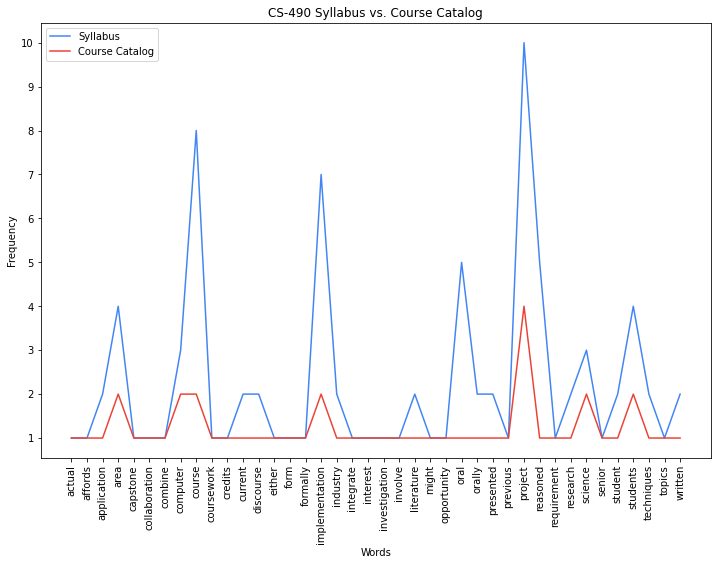

In [ ]:
#COURSE CATALOG

#pulls data from the URL and writes it into a string
cataURL = "https://raw.githubusercontent.com/annanardelli/SRP2021/main/UndergraduateCourseCatalog.txt"
cataPage = requests.get(cataURL)
cataData = cataPage.text
cataData = cataData.splitlines()

#runs a search of the CC document for each relevant course description
descList = []
course = 0
for index, item in enumerate(cataData):
    #print(index, item)
    if item.startswith(courses[course]):
        if ("Credits: " in cataData[index + 1]) or ("Credits: " in cataData[index]):
            descList.append(desc(cataData, index)) 
        if course < (len(courses) - 2):
            course += 1

count = -1
courseLength = len(courses)
for i in range(courseLength):
    count += 1
    wordFrequency(sylList[i],descList[i],"cc",count)

In [ ]:
#OUTCOMES

#pulls data from the URL and writes it into a string
outcomesURL = "https://raw.githubusercontent.com/annanardelli/SRP2021/main/CSSEOutcomesText/CSOutcomesForSRP.txt"
outcomesPage = requests.get(outcomesURL)
outcomesData = outcomesPage.text
outcomesList = []

tokens = word_tokenize(outcomesData) 
#convert to lower case
tokens = [w.lower() for w in tokens]
#remove punctuation from each word
table = str.maketrans('', '', string.punctuation)
stripped = [w.translate(table) for w in tokens]
#remove remaining tokens that are not alphabetic
words = [word for word in stripped if word.isalpha()]
#filter out stop words
stop_words = set(stopwords.words('english'))
new_stopwords = ['ł']
new_stopwords_list = stop_words.union(new_stopwords)
words = [w for w in words if not w in new_stopwords_list]
outcomesList.append(words)      
count = -1
for i in range(courseLength):
    count += 1
    wordFrequency(sylList[i],outcomesList[0], "outcomes", count) 

In [ ]:
#CHARTS
plt.figure(figsize=(20,8)) 
x_axis = np.arange(len(courses))
  
plt.bar(x_axis - 0.2, wordSimCC, 0.35, label = 'Syllabus vs. CC', align = 'center', color = colors[0])
plt.bar(x_axis + 0.2, wordSimOut, 0.35, label = 'Syllabus vs. Outcomes', align = 'center', color = colors[1])
  
plt.xticks(x_axis, courses)
plt.xticks(rotation=90)
plt.xlabel("Courses")
plt.ylabel("Word Similarity Measure")
plt.title("Word Similarity for Each Course")
plt.legend()
plt.savefig('WordSimilarity.png')
plt.show()

In [ ]:
#AVERAGE
wordSimAverages = []
count = 0
for i in wordSimCC:
    avg = 0
    total = 0
    total += i
    total += wordSimOut[count]
    count += 1
    avg = total / 2
    wordSimAverages.append(avg)

df = pd.DataFrame(wordSimAverages, index=courses, columns= ['Average'])
df = df.sort_values(by=['Average'],ascending=False)
#print(df)
x = df.plot.barh(rot=0, figsize=(12,8), title = "Average Word Similarity for Each Course", xticks = df['Average'], width = 0.7, color = colors)
x.set_ylabel("Course")
x.set_xlabel("Average Word Similarity Measure")
maxVal = max(df['Average']+0.1)
x.xaxis.set_ticks(np.arange(0, maxVal, 0.2))
x.get_legend().remove()
fig = x.get_figure()
fig.savefig('AverageWordSimilarity.png')